We are using time-series data found on Kaggle on US housing trends to analyze correlations between average home values, average time on market, and average price cuts. The dataset contains the average home value by city by month from 2000-2024, and from 2018-2024 it includes monthly data about average time on market and price cuts. 

The dataset can be found here, or otherwise in the project file: https://www.kaggle.com/datasets/clovisdalmolinvieira/us-housing-trends-values-time-and-price-cuts

The dataset has a number of missing values, which we handle by dropping rows with consecutive missing values (by category of data, e.g. `HomeValue`, `DaysPending`, etc) or in which the first or last values are missing, and imputing non-consecutive missing data from surrounding values (or in the case of price cuts, setting such a value to 0, or really a tiny epsilon, a somewhat arbitrary decision that can be easily modified). Though this cleaning approach is aggressive and kind of ham-fisted, the dataset is quite large and remains rich even after cleaning it this way.

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller

df = pd.read_csv('USRealEstateTrends.csv')

# Cleaning the dataset:
# The dataset includes values for avg home price by city by month 2000-present (5/2024),
# and for 2018-, contains price cuts and avg time on market.
# 
# If a row has multiple consecutive missing values per "category" (column name contains
# `HomePrice`,`CutRaw`,`DaysPending`), or the first or last values are missing, drop the entire row.

epsilon = 1e-10

def clean_data(df):

    categories = ['HomeValue', 'CutRaw', 'DaysPending']

    rows_to_drop = []    # to hold the indices of rows to drop

    for category in categories:
        # get the columns for this category
        category_cols = [col for col in df.columns if category in col]

        # go through each row in the dataframe
        for i in range(len(df)):
            # if the first or last row is missing values, add it to the list of rows to drop
            if i == 0 or i == len(df) - 1:
                if df[category_cols].iloc[i].isnull().any():
                    rows_to_drop.append(i)
                    continue

            # if this row has a missing value, handle it based on the category
            for col in category_cols:
                if pd.isnull(df.loc[i, col]):
                    if category == 'CutRaw':
                        # for 'CutRaw', replace missing values with 0 (really a tiny epsilon = 1^(-10))
                        df.loc[i, col] = epsilon
                    else:
                        # for 'HomeValue' and 'DaysPending', impute or drop based on surrounding values
                        prev_col = category_cols[category_cols.index(col) - 1]
                        next_col = category_cols[(category_cols.index(col) + 1) % len(category_cols)]
                        if not pd.isnull(df.loc[i, prev_col]) and not pd.isnull(df.loc[i, next_col]):
                            # if the previous and next columns have non-missing values, impute the missing value
                            df.loc[i, col] = (df.loc[i, prev_col] + df.loc[i, next_col]) / 2
                        else:
                            # if the previous or next column has a missing value, add the row to the list of rows to drop
                            rows_to_drop.append(i)

    # drop all rows that need to be dropped
    df = df.drop(rows_to_drop)

    return df

df = pd.read_csv('USRealEstateTrends.csv')
df = clean_data(df)
df.to_csv('Cleaned_USRealEstateTrends.csv', index=False)

This time-series data is non-stationary (i.e. does not have a constant mean and variance over time), which we can reasonably infer from the fact that housing prices are affected by trends, boom-bust cycles, seasons, etc. More rigorously, we can use the augmented Dickey-Fuller test to demonstrate with 99% certainty that this time-series data is indeed not stationary. (In the ADF test, the null hypothesis is that the time-series data is *non-stationary*. If the test statistic is less than the critical value at a certain confidence level, we fail to reject the null hypothesis. Observe that the critical values below are consistently less than the test statistic, implying the data is non-stationary. We can also look at the $p$-values: if they are less than, for instance, 0.05, we reject the null hypothesis. Observe that the $p$-values returned are extremely high (~.99), so we fail to reject the null hypothesis and assume with 95% certainty that the data is *non-stationary*.)

In [2]:
from statsmodels.tsa.stattools import adfuller

def run_adfuller_test(series):
    """
    Run the Augmented Dickey-Fuller test on a given series.

    Parameters:
    series (pd.Series): The time series data.

    Returns:
    dict: A dictionary containing the test statistic, p-value, number of lags used,
          number of observations, and critical values.
    """

    result = adfuller(series)

    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '#Lags Used': result[2],
        '#Observations Used': result[3],
        'Critical Value (1%)': result[4]['1%'],
        'Critical Value (5%)': result[4]['5%'],
        'Critical Value (10%)': result[4]['10%'],
    }

    return output

results = {}
homevalue_columns = [col for col in df.columns if 'HomeValue' in col]
for index, row in df[homevalue_columns].iterrows():
    results[index] = run_adfuller_test(row)
for index, result in results.items():
    print(f"Results for index {index}:")
    print(result)
    print("\n")

Results for index 0:
{'Test Statistic': 0.280808252462644, 'p-value': 0.9764466429592575, '#Lags Used': 15, '#Observations Used': 276, 'Critical Value (1%)': -3.4542672521624214, 'Critical Value (5%)': -2.87206958769775, 'Critical Value (10%)': -2.5723807881747534}


Results for index 1:
{'Test Statistic': -0.6443360615591888, 'p-value': 0.8606459714995169, '#Lags Used': 15, '#Observations Used': 276, 'Critical Value (1%)': -3.4542672521624214, 'Critical Value (5%)': -2.87206958769775, 'Critical Value (10%)': -2.5723807881747534}


Results for index 2:
{'Test Statistic': -0.457980520500763, 'p-value': 0.8999587917954774, '#Lags Used': 14, '#Observations Used': 277, 'Critical Value (1%)': -3.4541800885158525, 'Critical Value (5%)': -2.872031361137725, 'Critical Value (10%)': -2.5723603999791473}


Results for index 3:
{'Test Statistic': -0.6326053975678344, 'p-value': 0.8634430499561223, '#Lags Used': 16, '#Observations Used': 275, 'Critical Value (1%)': -3.454355055831705, 'Critical Va

Here the model tries to predict some values. It doesn't do so very well, however.

Cross-validation scores: [-8.70295162 -0.15926007 -0.609633    0.98649898  0.14860429]
Average cross-validation score: -1.667348282615387
      Actual  Predicted
0   0.691252   0.595845
1   0.691606   0.597159
2   0.701504   0.596811
3   0.718402   0.596369
4   0.743267   0.596544
5   0.766124   0.598380
6   0.792415   0.601512
7   0.816319   0.606224
8   0.835264   0.611948
9   0.838744   0.617213
10  0.829403   0.620387
11  0.822420   0.620206
12  0.839485   0.617312
13  0.877298   0.613532
14  0.932042   0.610489
15  0.996314   0.609012
16  1.057484   0.608196
17  1.121431   0.606253
18  1.180793   0.600813
19  1.240290   0.590273
20  1.297657   0.573120
21  1.349106   0.548171
22  1.392001   0.514038
23  1.417816   0.470595
24  1.433576   0.420523
25  1.455811   0.367856
26  1.491487   0.314659
27  1.531713   0.261876
28  1.574477   0.210539
29  1.621554   0.160677
30  1.685733   0.112462
31  1.753260   0.064052
32  1.821398   0.015351
33  1.883738  -0.033554
34  1.923409  -0.08213

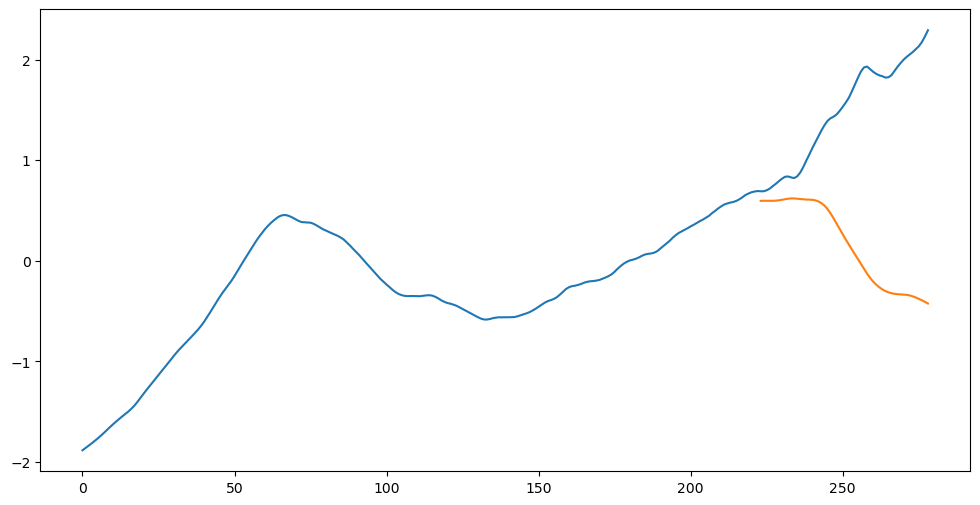

In [3]:
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


df = df.loc[[1]] # for now, restrict to row 1, i.e. New York City

home_value_cols = [col for col in df.columns if 'HomeValue' in col]
df = df[home_value_cols]

data = df.values.flatten()   # convert the dataframe to a 1D array

# scale the data
data = data.reshape(-1, 1)
scaler = StandardScaler()
data = scaler.fit_transform(data).flatten()

# create lagged dataset
look_back = 12
X, Y = [], []
for i in range(len(data)-look_back-1):
    X.append(data[i:(i+look_back)])
    Y.append(data[i + look_back])
X = np.array(X)
Y = np.array(Y)

train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

model = SVR(kernel='rbf', C=1, gamma=0.1)

# perform cross-validation
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X_train, Y_train, cv=tscv, scoring='r2')

print(f"Cross-validation scores: {scores}")
print(f"Average cross-validation score: {scores.mean()}")

model.fit(X_train, Y_train)

trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

comparison_df = pd.DataFrame({'Actual': Y_test, 'Predicted': testPredict})
print(comparison_df)

plt.figure(figsize=(12,6))
plt.plot(Y)
plt.plot([None for _ in Y_train] + [x for x in testPredict])
plt.show()

Since we showed the data is non-stationary, we want to difference it before training and testing a predictive model on it, since time-series forecasting models typically assume a constant mean and variance in the data. Maybe this will improve the predictive performance.

Trying techniques to make it stationary:
- Natural log of dataset
- STL (Seasonal and Trend decomposition using Loess)
- pandas seasonal differencing

We run ADF again to see whether our data is stationary now. An improvement, but not stationary yet.

In [6]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Load the dataset
df = pd.read_csv('USRealEstateTrends.csv')

# Filter columns that contain 'HomeValue'
home_value_cols = [col for col in df.columns if 'HomeValue' in col]
df = df[home_value_cols]

# Apply differencing along rows
df = df.diff(axis=1)

# Save the differenced data to a new CSV file
df.to_csv('Differenced_HomeValues_USRealEstateTrends.csv', index=False)

def run_adfuller_test(series):
    # Drop NaN values and check if the series is long enough for ADF test
    series = series.dropna()
    if len(series) > 20:  # ADF requires a reasonable number of data points
        result = adfuller(series)
        return result
    else:
        return "Insufficient data"

results = {}
for index, row in df.iterrows():
    results[index] = run_adfuller_test(row)
for index, result in results.items():
    print(f"Results for index {index}:")
    print(result)
    print("\n")


Results for index 0:
(-2.6531315557589688, 0.0825055671385605, 14, 276, {'1%': -3.4542672521624214, '5%': -2.87206958769775, '10%': -2.5723807881747534}, 3627.7934903816226)


Results for index 1:
(-2.3017134913098243, 0.17141593201602534, 16, 274, {'1%': -3.4544435065994437, '5%': -2.8721468827772774, '10%': -2.572422013959188}, 4091.3302366297276)


Results for index 2:
(-2.867910543355672, 0.04920884136007905, 16, 274, {'1%': -3.4544435065994437, '5%': -2.8721468827772774, '10%': -2.572422013959188}, 4666.785751869119)


Results for index 3:
(-2.4385583084531075, 0.13114795884931962, 15, 275, {'1%': -3.454355055831705, '5%': -2.8721080938842976, '10%': -2.572401325619835}, 3927.8518007164384)


Results for index 4:
(-3.0769939327693305, 0.028303254204634313, 14, 274, {'1%': -3.4544435065994437, '5%': -2.8721468827772774, '10%': -2.572422013959188}, 3838.3785906261905)


Results for index 5:
(-3.075361838173578, 0.02843107161741962, 14, 276, {'1%': -3.4542672521624214, '5%': -2.87206